## A modelling/simulation mini-project: The SIR model and some extensions

In this somewhat longer exercise/mini project we take a closer look at the SIR model
briefly introduced in {prf:ref}`ode:exa:spreading-disease`, how to modify the model
to account for e.g. hospitalized patients of time-limited immunity, and how to solve
the resulting models numerically using Runge-Kutta methods.

### SIR model

Recall that the SIR model is given by

\begin{align}
S' &= - \beta S I
\\
I' &= \beta S I - \gamma I
\\
R' &= \gamma I,
\end{align}

where 
* S(t): porpotion of individuals  **susceptible** for infection,
* I(t): porpotion of **infected** individuals, capable of transmitting the disease,
* R(t): porpotion of **removed** individuals who cannot be infected due death or to immunity  

* $\beta$:  the **infection rate**, and
* $\gamma$: the **removal rate**. 

a) Show that the total number of induviduals $N(t)$ is constant with respect to time 

**Solution**

We see that: 
\begin{align}
 N'(t) = S'(t) + I'(t) + R'(t) = 0 
\end{align}

b) Looking at $$ I' = \beta S I - \gamma I$$ we see that an outbreak of a disease (increase of number of infections) can only occur
if $I'(0) > 0$, equivalent to 
$$
0 < \beta S(0) I(0) - \gamma I(0) \Leftrightarrow \underbrace{\dfrac{\beta}{\gamma}}_{:=R_0} S(0) > 1 
$$

Use Heuns Method to solve the SIR model . Assume we are modelling Trondheim with 200000 habitants, and start with one infected induvidual, and set $ \gamma = 1/18 $.  Test with different values for $R_0$ and see what the result is. 


**Solution**

In [16]:
%matplotlib widget
# %matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact, fixed
import numpy as np
from numpy import pi
from numpy.linalg import solve, norm    
import matplotlib.pyplot as plt



In [17]:
#same as lecture notes 
class ExplicitRungeKutta:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, y0, t0, T, f, Nmax):
        # Extract Butcher table
        a, b, c = self.a, self.b, self.c
        
        # Stages
        s = len(b)
        ks = [np.zeros_like(y0, dtype=np.double) for s in range(s)]

        # Start time-stepping
        ys = [y0]
        ts = [t0]
        dt = (T - t0)/Nmax
        
        while(ts[-1] < T):
            t, y = ts[-1], ys[-1]
            
            # Compute stages derivatives k_j
            for j in range(s):
                t_j = t + c[j]*dt
                dY_j = np.zeros_like(y, dtype=np.double)
                for l in range(j):
                    dY_j += dt*a[j,l]*ks[l]

                ks[j] = f(t_j, y + dY_j)
                
            # Compute next time-step
            dy = np.zeros_like(y, dtype=np.double)
            for j in range(s):
                dy += dt*b[j]*ks[j]
            
            ys.append(y + dy)
            ts.append(t + dt)
            
        return (np.array(ts), np.array(ys))
    
a    = np.array([[0,   0],
                 [1., 0]])
b = np.array([1/2, 1/2.])
c = np.array([0., 1])
    
heun = ExplicitRungeKutta(a, b, c)


In [18]:
class SIR:
    def __init__(self, beta, gamma):
        self.beta = beta # infectional rate
        self.gamma = gamma # removal rate
    
    def __call__(self, t, y):
        return np.array([-self.beta*y[0]*y[1],
                          self.beta*y[0]*y[1] - self.gamma*y[1],
                          self.gamma*y[1]])
        

In [19]:
# Data for the SIR model
# denote basic reproduction number by r0
r0 = 2
gamma = 1/18.
beta = r0*gamma

# Define a model
sir = SIR(beta=beta, gamma=gamma)

# Trondheim has 200.000 inhabitants we start with 1 infected person
I_0 = 1/200000
S_0 = 1 - I_0
R_0 = 0

y0 = np.array([S_0, 
               I_0,
               R_0])

t0, T = 0, 1000 # days, we consider a whole year



# Run method
Nmax = 10000
ts, ys = heun(y0, t0, T, sir, Nmax)


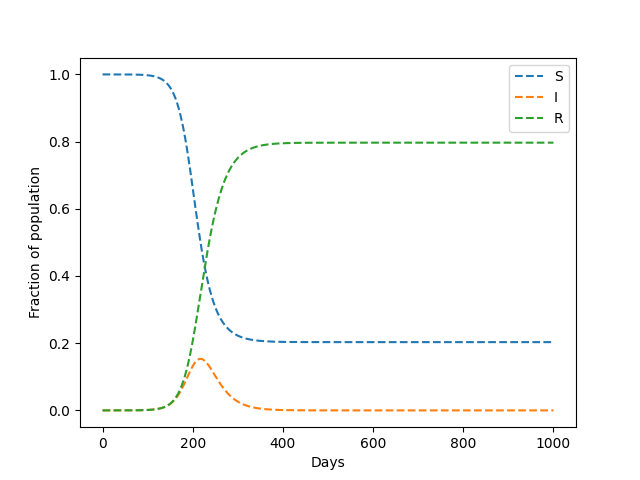

In [20]:
plt.figure()
plt.plot(ts, ys, "--")
plt.legend(["S", "I", "R"])
plt.xlabel("Days")
plt.ylabel("Fraction of population")
plt.show()

### SIRH model

We now look at the SIHR model, which also includes the number of hopsitalized induviduals 

The SIHR model is given by 

\begin{align}
S' &= - \beta S I
\\
I' &= \beta S I - \gamma_r I - \gamma_h I
\\
H' &= \gamma_h I - \delta H
\\
R' &= \gamma_r I + \delta H ,
\end{align}

we assume the same total $\gamma$ as for the simpler SIR model; that is,
$$
\gamma_r + \gamma_h =: \gamma = 1/18
$$

   Assume that
   *  we have  the same total $\gamma$ as for the simpler SIR model; that is, $ \gamma_r + \gamma_h =: \gamma = 1/18 $
   *  that 3.5% of all infected individuals will be hospitalized which means that $\gamma_h = 0.035\gamma$
   *  hospitalized individuals stay 14 days in the hospital on average, that is $\delta = 1/14$
   *  St. Olav's hospital has roughly 1000 beds with roughly 80% of them being occupied

Again startin with one infected induvidual, find what is (approximately) the largest basic reproduction number $R_0$ for which we will not exceed the maximal number of available beds?


**Solution**

Note that the solution code provided below uses some more sophisticated Jupyter widgets features, but it is just used 
as extra interface sugar. We will use a simple slider interface which sets the basic reproduction number $R_0$ and then automatically updates
the solution plots.


In [21]:
# define SIHR class similar to SIR before
class SIHR:
    def __init__(self, beta, gamma_r, gamma_h, delta):
        self.beta = beta # infectional rate
        self.gamma_r = gamma_r # removal rate
        self.gamma_h = gamma_h # removal rate
        self.delta = delta
    
    def __call__(self, t, y):
        return np.array([-self.beta*y[0]*y[1],
                          self.beta*y[0]*y[1] - self.gamma_r*y[1]-self.gamma_h*y[1],
                          self.gamma_h*y[1] - self.delta*y[2],
                          self.gamma_r*y[1]+self.gamma_h*y[2]])

# initial data
# Trondheim has 200.000 inhabitants we start with 1 infected person
N = 2.0e5
I_0 = 1/N
S_0 = 1 - I_0
H_0 = 0
R_0 = 0

y0 = np.array([S_0, 
               I_0,
               H_0,
               R_0])
Nyears = 2
t0, T = 0, Nyears*365 # days, we consider 2 years year

In [22]:
# Prepare plot
Nbeds = 1000
Nfree_beds = 200

# def plot_dynamics_sihr(r0, solver, ax):
def plot_dynamics_sihr(r0, solver, ax):
    # Orginal removal rate from SIR model
    gamma = 1/18.
    beta = r0*gamma
    # We split it into gamma = gamma_r + gamma_h
    # assuming that 3.5 % are hospitalized
    gamma_h =0.035*gamma
    gamma_r = gamma - gamma_h
    # Assume 14 days of hospitilization
    delta = 1./14

    # Define a model for given r0
    sihr = SIHR(beta=beta, gamma_h=gamma_h, gamma_r=gamma_r, delta=delta)

    # Solve
    ts, ys = solver(y0, t0, T, sihr, Nmax)
    ax[0].clear()
    ax[0].plot(ts, ys, "--", markersize=3)
    ax[0].legend(["S", "I", "H", "R"])
    ax[0].set_xlim(0,Nyears*365)
    ax[0].set_ylim(0, 1.0)
    ax[0].set_xlabel("Days")
    ax[0].set_ylabel("Fraction of population")

    ax[1].clear()
    ax[1].plot(ts, 2e5*ys[:,2], "--", markersize=3, label="H")
    ax[1].legend()
    ax[1].set_xlabel("Days")
    ax[1].set_ylabel("Number of hospitalized persons")
    ax[1].set_xlim(0,Nyears*365)
    ax[1].set_ylim(0, Nbeds)
    ax[1].hlines([Nfree_beds], t0,T, colors="r", linestyles="dashed")
    ax[1].annotate('Max capacity of \nadditional available beds', 
             xy=(500, Nfree_beds), xytext=(-50, 50), 
             textcoords="offset points",
             arrowprops=dict(arrowstyle="simple",facecolor='black', 
                             relpos=(0.315,0)))
    print(f"Maximum of additional Covid 19 caused hospitalization: {np.abs(ys[:,2]).max()*200000}")

interactive(children=(FloatSlider(value=2.0, description='r0', max=3.0, min=1.0, step=0.01), Output()), _dom_c…

<function __main__.plot_dynamics_sihr(r0, solver, ax)>

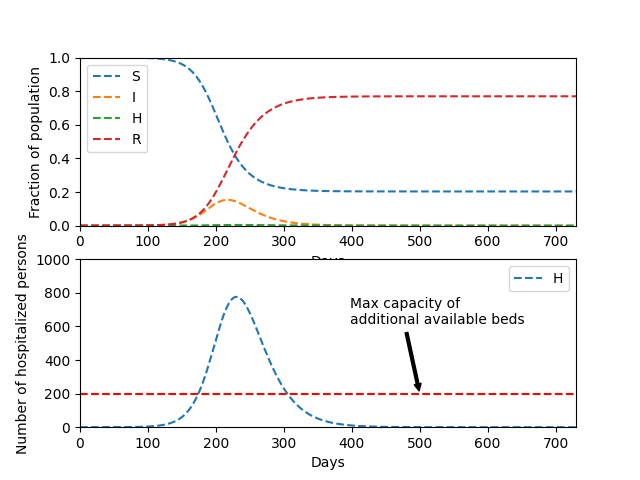

In [23]:
plt.close()
fig, ax = plt.subplots(2,1)
widgets.interact(plot_dynamics_sihr, r0=(1.0, 3.0, 0.01), solver=fixed(heun), ax=fixed(ax))
# widgets.interact(plot_dynamics_sihr, r0=(1.0, 3.0, 0.01), solver=fixed(heun), ax=fixed(ax))
# pds = lambda r0 : plot_dynamics_sihr(r0, heun, ax)
# widgets.interact(pds, r0=(1.0, 3.0, 0.01))


### SIHRt model

Redo part 2, but this time develop and use an extension the SIHR model to account for time-limited immunity, assuming 1 year of immunity for each recovered person. Consider a time-period of 5 years and
find out how many "infection waves" will occur where the maximum capacity of beds are exceeded. 

**Solution.**
  * For $R_0=2$ there are 2 waves, one around Day 250 and one around Day 805
  

In [ ]:
class SIHRt:
    def __init__(self, beta, gamma_r, gamma_h, delta, sigma):
        self.beta = beta # infectional rate
        self.gamma_r = gamma_r # removal rate
        self.gamma_h = gamma_h # removal rate
        self.delta = delta
        self.sigma = sigma
    
    def __call__(self, t, y):
        return np.array([-self.beta*y[0]*y[1]+self.sigma*y[3],
                          self.beta*y[0]*y[1] - self.gamma_r*y[1]-self.gamma_h*y[1],
                          self.gamma_h*y[1] - self.delta*y[2],
                          self.gamma_r*y[1]+self.gamma_h*y[2]-self.sigma*y[3]])

In [ ]:
# Prepare plot
Nbeds = 1000
Nfree_beds = 200

Nyears = 5
t0, T = 0, Nyears*365 # days, we consider 5 years year

def plot_dynamics_sihrt(r0, solver, ax):
    ##### Data for the SIHRt model
    # Orginal removal rate from SIR model
    # We split it into gamma = gamma_r + gamma_h
    # assuming that 3.5 % are hospitalized
    gamma = 1/18.
    beta = r0*gamma
    gamma_h =0.035*gamma
    gamma_r = gamma - gamma_h
    # Assume 14 days of hospitilization
    delta = 1./14
    # One year of immunization
    sigma = 1/365.

    # Define a model for given r0
    sihrt = SIHRt(beta=beta, gamma_h=gamma_h, gamma_r=gamma_r, delta=delta, sigma=sigma)

    # Solve
    ts, ys = solver(y0, t0, T, sihrt, Nmax)
    ax[0].clear()
    ax[0].plot(ts, ys, "--", markersize=3)
    ax[0].legend(["S", "I", "H", "R"])
    ax[0].set_xlim(0,Nyears*365)
    ax[0].set_ylim(0, 1.0)
    ax[0].set_xlabel("Days")
    ax[0].set_ylabel("Fraction of population")

    ax[1].clear()
    ax[1].plot(ts, 2e5*ys[:,2], "--g", markersize=3, label="H")
    ax[1].legend()
    ax[1].set_xlabel("Days")
    ax[1].set_ylabel("Number of hospitalized persons")
    ax[1].set_xlim(0,Nyears*365)
    ax[1].set_ylim(0, Nbeds)
    ax[1].hlines([Nfree_beds], t0,T, colors="r", linestyles="dashed")
    ax[1].annotate('Max capacity of \nadditional available beds', 
             xy=(500, Nfree_beds), xytext=(-50, 50), 
             textcoords="offset points",
             arrowprops=dict(arrowstyle="simple",facecolor='black', 
                             relpos=(0.315,0)))
    print(f"Maximum of additional Covid 19 caused hospitalization: {np.abs(ys[:,2]).max()*200000}") 

In [ ]:
plt.close()
fig, ax = plt.subplots(2,1)
widgets.interact(plot_dynamics_sihrt, r0=(1.0, 3.0, 0.01), solver=fixed(heun), ax=fixed(ax))